# Time series forecasting
Get data from weather logging, and try to predict some parameters. Data is found online.
Example is from keras/tensorflow

In [1]:
# Some imports
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Some settigns for plotting
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

## Downloading the data

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

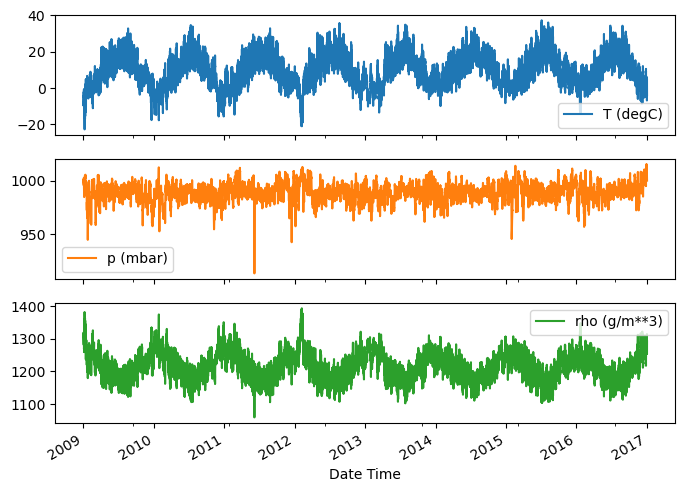

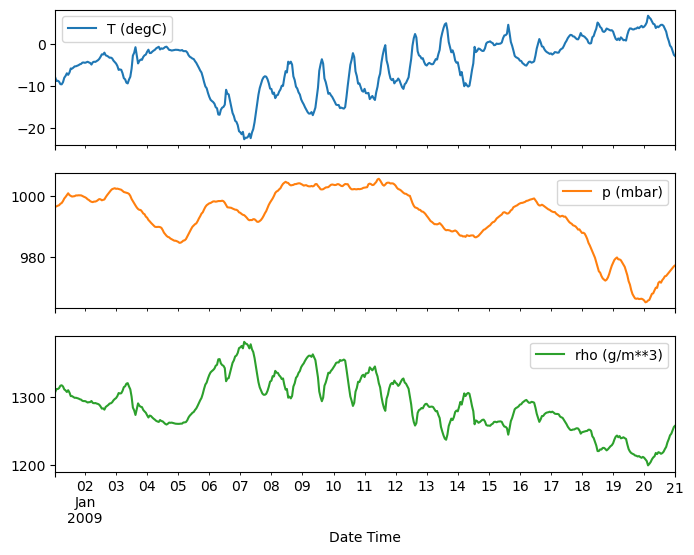

In [3]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], and we want every 60 minutes, i.e. once every hour, starting from the 5th value
df=df[5::6]
date_time= pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [4]:
# Look at some statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [5]:
# Since we have an error in the wv min column/row, we'll remove it and replace it with 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

## Preprocessing
We want to change some of the formatting of the data so that we can use it.
This includes moving to radians instead of degrees, and go from datetime as a string to seconds.

In [6]:
# Remove headers
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
# Load seconds 
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

# Map seconds to a periodic signal(sin/cos)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

## Assumption/justification
There is an assumption that the parameters heavily depend upon time of day and year, which is logical. 
We will justify this assumption by looking at the data as signals, and use FFT to see where there is varuiations.
If the assumption is correct, we will have spikes over the frequencies corresponding to a year and a day in the spectrum.

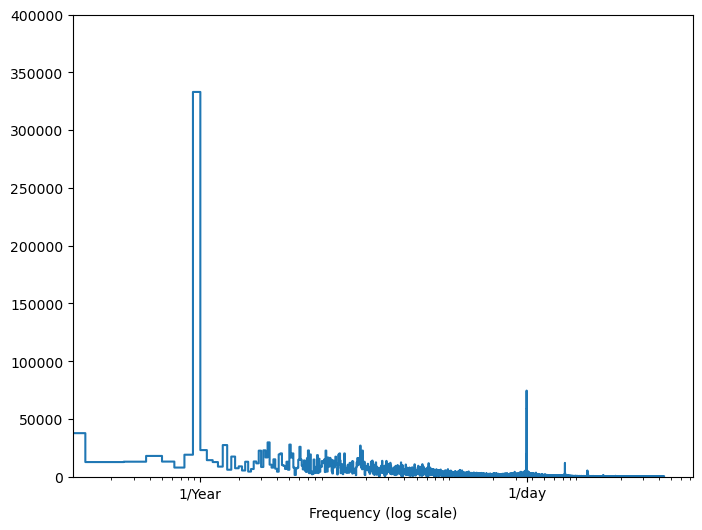

In [7]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Data split
We will use 70% of the data to train, 20% to validate, and 10% to test 

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df=df[0:int(n*0.7)]
val_df=df[int(n*0.7):int(n*(0.7+0.2))]
test_df=df[int(n*0.9):]
num_features=df.shape[1]
print(f'we have {num_features} features')

we have 19 features


 ## Normalization
 We also need to normalize the dtaa so that it is usable.
 This is done by subtracting the mean and dividing by the standard deviation of each feature.
 To do this properly, we need to divide all the sets by the same eman, and we'll use the training mean/std for this

In [9]:
train_mean=train_df.mean()
train_std=train_df.std()

train_df=(train_df - train_mean)/train_std
val_df=(val_df - train_mean)/train_std
test_df=(test_df - train_mean)/train_std


In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')